In [1]:
import cv2
import numpy as np
from CDA.dataset_reader import read_dataset
from skimage.metrics import structural_similarity as ssim
from CDA.CNN_denoiser import CNN_denoiser
import matplotlib.pyplot as plt
import os
import imageio
from PIL import Image

2023-11-22 02:44:38.682212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 02:44:38.687475: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 02:44:38.733400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 02:44:38.734140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 02:44:40.546295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
def add_noise(pure, pure_val, pure_test, noise_mean, noise_std, noise_prop):
    noise = np.random.normal(noise_mean, noise_std, pure.shape)  # np.random.poisson(1, pure.shape)
    noise_test = np.random.normal(noise_mean, noise_std, pure_test.shape) # np.random.poisson(1, pure_test.shape)
    noise_val = np.random.normal(noise_mean, noise_std, pure_val.shape) 
    noisy_input = pure + noise_prop * noise
    noisy_input_test = pure_test + noise_prop * noise_test
    noisy_input_val = pure_val + noise_prop * noise_val
    return noisy_input, noisy_input_val, noisy_input_test

In [7]:
batch_size = 10

train_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia//chest_xray/train"
val_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val"
test_dir = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/test"


In [8]:
train_input = read_dataset(train_dir, img_height=224, img_width=224)
val_input = read_dataset(val_dir, img_height=224, img_width=224)
test_input = read_dataset(test_dir, img_height=224, img_width=224)

In [9]:
# Parse numbers as floats
train_input = train_input.astype('float32')
val_input = val_input.astype('float32')
test_input = test_input.astype('float32')

# Normalize data
train_input = train_input / 255
val_input = val_input / 255
test_input = test_input / 255


pure = train_input
pure_val = val_input
pure_test = test_input

noisy_input, noisy_input_val, noisy_input_test = add_noise(pure, pure_val, pure_test, noise_mean=0, noise_std=1, noise_prop=0.1)

In [11]:
# Create the model
cnn_denoiser = CNN_denoiser(batch_size=batch_size, nu_epochs=15, validation_split=0.2, img_height=224, img_width=224)

print("[LOG] Training and evaluating model...")
# Train the model and save the history
history = cnn_denoiser.train(noisy_input, pure, save=True, verbosity=1)

# Evaluate the model on the validation set
cnn_denoiser.evaluate(noisy_input_val, pure_val)

# Make predictions on a test set
samples = noisy_input_test[:]
print("[LOG] Training and model evaluation completed\n[LOG] Denoising images test set...")
denoised_images = cnn_denoiser.predict(samples)

2023-11-16 16:34:35.696322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 16:34:35.696562: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 up_sampling2d (UpSampling2  (None, 112, 112, 128)     0

/home/branislava.jankovic/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 - 0s - loss: 0.5398 - accuracy: 0.0661 - 348ms/epoch - 348ms/step
[EVALUATION] Test loss: 0.5398382544517517
[EVALUATION] Test accuracy: 0.06614840030670166
[LOG] Training and model evaluation completed
[LOG] Denoising images test set...
20/20 [==============================] - 13s 637ms/step


In [12]:
# Access the training history
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']

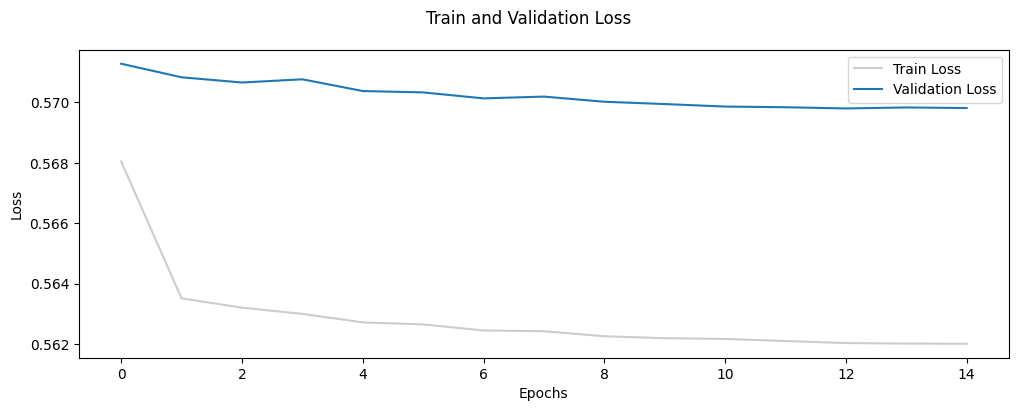

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    loss_values,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_loss_values, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_224")

_ = ax.legend()

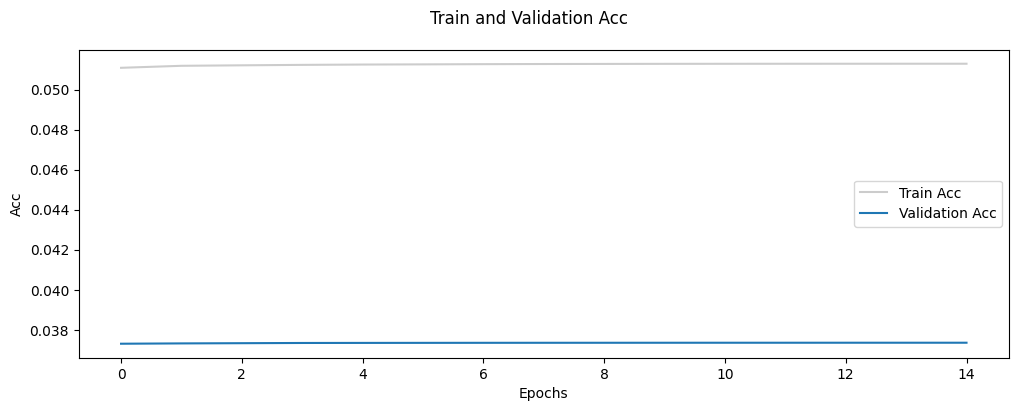

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    accuracy_values,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_accuracy_values, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_224")

_ = ax.legend()

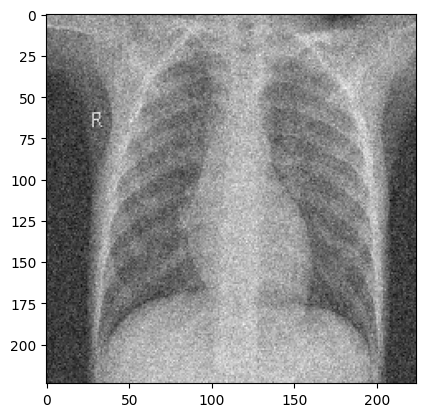

In [15]:
plt.imshow(noisy_input_test[0], plt.cm.gray)

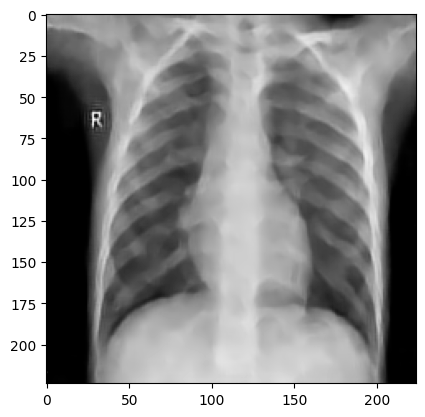

In [16]:
plt.imshow(denoised_images[0], plt.cm.gray)

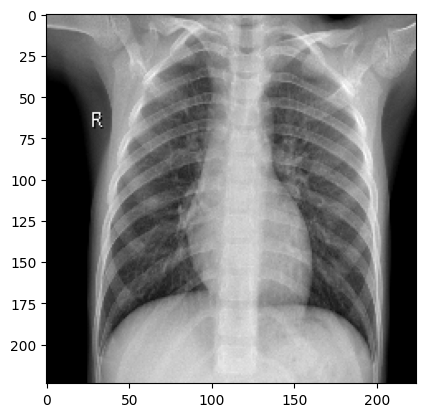

In [17]:
plt.imshow(pure_test[0], plt.cm.gray)

#########################################################################################################################

### Denoising entire dataset

In [18]:
train_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/train/NORMAL"
train_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/train/PNEUMONIA"

val_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val/NORMAL"
val_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val/PNEUMONIA"

test_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/test/NORMAL"
test_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/test/PNEUMONIA"

In [3]:
def kalils_read_dataset(path=None, img_width=64, img_height=64):
    try:
        images = []
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)

        return np.array(images)
    except Exception as e:
        print(f"Error has occurred during data loading: {e}")

In [20]:
train_input0 = kalils_read_dataset(train_dir0, img_height=224, img_width=224)
train_input1 = kalils_read_dataset(train_dir1, img_height=224, img_width=224)

val_input0 = kalils_read_dataset(val_dir0, img_height=224, img_width=224)
val_input1 = kalils_read_dataset(val_dir1, img_height=224, img_width=224)

test_input0 = kalils_read_dataset(test_dir0, img_height=224, img_width=224)
test_input1 = kalils_read_dataset(test_dir1, img_height=224, img_width=224)

In [21]:
# Parse numbers as floats
train_input0 = train_input0.astype('float32')
train_input1.astype('float32')

val_input0 = val_input0.astype('float32')
val_input1 = val_input1.astype('float32')

test_input0 = test_input0.astype('float32')
test_input1 = test_input1.astype('float32')


# Normalize data
train_input0 = train_input0 / 255
train_input1 = train_input1 / 255

val_input0 = val_input0 / 255
val_input1 = val_input1 / 255

test_input0 = test_input0 / 255
test_input1 = test_input1 / 255

In [23]:
denoised_train_input0 = cnn_denoiser.predict(train_input0)
denoised_val_input0 = cnn_denoiser.predict(val_input0)
denoised_ttest_input0 = cnn_denoiser.predict(test_input0)

denoised_train_input1 = cnn_denoiser.predict(train_input1)
denoised_val_input1 = cnn_denoiser.predict(val_input1)
denoised_ttest_input1 = cnn_denoiser.predict(test_input1)

13/13 [==============================] - 9s 654ms/step


In [26]:
# Function to save all the images
def save_images(image_list, directory, base_filename):
    for i, img in enumerate(image_list):
        # Ensure the image has 3 channels
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = (img * 255).astype('uint8')  # Scale values to 0-255
            img = np.stack((img,) * 3, axis=-1)

        # Convert NumPy array to PIL Image
        pil_img = Image.fromarray(img)

        # Save the image
        pil_img.save(f'{directory}/{base_filename}_{i}.png')

In [27]:
# Call the function for each set of images
save_images(denoised_train_input0, "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/train/NORMAL", 'denoised_train_input')
save_images(denoised_train_input1, "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/train/PNEUMONIA", 'denoised_train_input')

save_images(denoised_val_input0, '/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val/NORMAL', 'denoised_val_input')
save_images(denoised_val_input1, '/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val/PNEUMONIA', 'denoised_val_input')

save_images(denoised_ttest_input0, '/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/test/NORMAL', 'denoised_test_input')
save_images(denoised_ttest_input1, '/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/test/PNEUMONIA', 'denoised_test_input')

##################################################################################################################################################################

### Calculaing SSIM and PSNR metrics  

SSIM is a measure of similarity between two images (1: perfect similarity, 0 no similarity, -1 perfect anti correlation)

In [55]:
train_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/train/NORMAL"
train_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/train/PNEUMONIA"

val_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val/NORMAL"
val_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val/PNEUMONIA"

test_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/test/NORMAL"
test_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/test/PNEUMONIA"

In [56]:
train_input0 = kalils_read_dataset(train_dir0, img_height=224, img_width=224)
train_input1 = kalils_read_dataset(train_dir1, img_height=224, img_width=224)

val_input0 = kalils_read_dataset(val_dir0, img_height=224, img_width=224)
val_input1 = kalils_read_dataset(val_dir1, img_height=224, img_width=224)

test_input0 = kalils_read_dataset(test_dir0, img_height=224, img_width=224)
test_input1 = kalils_read_dataset(test_dir1, img_height=224, img_width=224)

In [57]:
d_train_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/train/NORMAL"
d_train_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/train/PNEUMONIA"

d_val_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val/NORMAL"
d_val_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val/PNEUMONIA"

d_test_dir0 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/test/NORMAL"
d_test_dir1 = "/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/test/PNEUMONIA"

In [58]:
d_train_input0 = kalils_read_dataset(d_train_dir0, img_height=224, img_width=224)
d_train_input1 = kalils_read_dataset(d_train_dir1, img_height=224, img_width=224)

d_val_input0 = kalils_read_dataset(d_val_dir0, img_height=224, img_width=224)
d_val_input1 = kalils_read_dataset(d_val_dir1, img_height=224, img_width=224)

d_test_input0 = kalils_read_dataset(d_test_dir0, img_height=224, img_width=224)
d_test_input1 = kalils_read_dataset(d_test_dir1, img_height=224, img_width=224)

In [3]:
# Load the images
cda_image = cv2.imread('/home/branislava.jankovic/Desktop/denoising-pneumonia/denoised_chest_xray/val/NORMAL/denoised_val_input_0.png')
original_image = cv2.imread('/home/branislava.jankovic/Desktop/denoising-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')
original_image = cv2.resize(original_image, (224, 224))

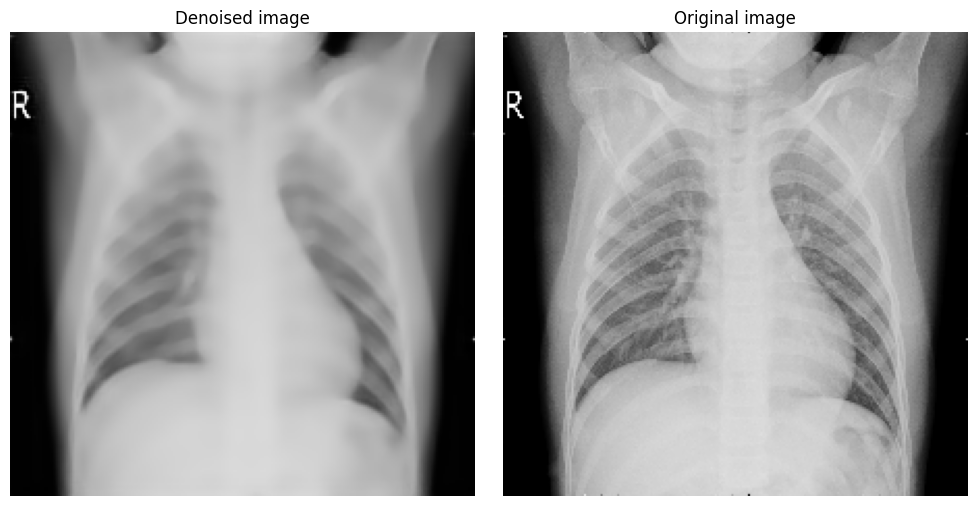

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the left subplot
axes[0].imshow(cda_image, cmap='gray')
axes[0].set_title('Denoised image')

# Display the second image on the right subplot
axes[1].imshow(original_image, cmap='gray')
axes[1].set_title('Original image')

# Hide the axis labels
for ax in axes:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

SSIM is a measure of similarity between two images (1: perfect similarity, 0 no similarity, -1 perfect anti correlation)

In [5]:
from skimage.metrics import structural_similarity as ssim

ssim_value = ssim(original_image, cda_image, win_size=3, multichannel=True)
print("SSIM for one picture:", ssim_value)

SSIM for one picture: 0.8263054166828228


In [2]:
def calculate_average_ssim(noisy_images, denoised_images):
    if len(noisy_images) != len(denoised_images):
        raise ValueError("The number of noisy and denoised images must be the same")

    total_ssim = 0.0
    for noisy, denoised in zip(noisy_images, denoised_images):
        # Ensure the images have the same shape
        if noisy.shape != denoised.shape:
            # Resize or adjust as necessary
            raise ValueError("The size of noisy and denoised images must be the same")

        ssim_value = ssim(noisy, denoised, multichannel=True)
        total_ssim += ssim_value

    average_ssim = total_ssim / len(noisy_images)
    return average_ssim

In [ ]:
# average_ssim_train_n = calculate_average_ssim(train_input0, d_train_input0)
# average_ssim_train_p = calculate_average_ssim(train_input1, d_train_input1)

# average_ssim_val_n = calculate_average_ssim(val_input0, d_val_input0)
# average_ssim_val_p = calculate_average_ssim(val_input1, d_val_input1)

# average_ssim_test_n = calculate_average_ssim(test_input0, d_test_input0)
# average_ssim_test_p = calculate_average_ssim(test_input1, d_test_input1)

# print("Average SSIM Train Normal:", average_ssim_train_n)
# print("Average SSIM Train Pneumonia:", average_ssim_train_p)

# print("Average SSIM val Normal:", average_ssim_val_n)
# print("Average SSIM val Pneumonia:", average_ssim_val_p)

# print("Average SSIM test Normal:", average_ssim_test_n)
# print("Average SSIM test Pneumonia:", average_ssim_test_p)

The PSNR (Peack Signal to Noise Ratio) is another effective method usually used to measure the change between the original image and its compressed version. It is also useful to use in measuring the effectiveness of reconstructting noisy images to reduce its noise.

$$\text{PSNR} = 10 \cdot \log_{10} \left( \frac{\text{MAX}^2}{\text{MSE}} \right)$$


In [64]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_average_psnr(noisy_images, denoised_images):
    total_psnr = 0.0
    for noisy, denoised in zip(noisy_images, denoised_images):
        if noisy.shape != denoised.shape:
            raise ValueError("The size of noisy and denoised images must be the same")

        psnr_value = calculate_psnr(noisy, denoised)
        total_psnr += psnr_value

    average_psnr = total_psnr / len(noisy_images)
    return average_psnr

In [67]:
one_image = calculate_psnr(cda_image, original_image)

average_psnr_train_n = calculate_average_psnr(train_input0, d_train_input0)
average_psnr_train_p = calculate_average_psnr(train_input1, d_train_input1)

average_psnr_val_n = calculate_average_psnr(val_input0, d_val_input0)
average_psnr_val_p = calculate_average_psnr(val_input1, d_val_input1)

average_psnr_test_n = calculate_average_psnr(test_input0, d_test_input0)
average_psnr_test_p = calculate_average_psnr(test_input1, d_test_input1)

In [68]:
print("Average PSNR Values:")
print()
print(f"  - The first noisy image and its denoised version: {one_image:.2f} dB")
print()
print(f"  - Train Normal: {average_psnr_train_n:.2f} dB")
print(f"  - Train Pneumonia: {average_psnr_train_p:.2f} dB")
print(f"  - Validation Normal: {average_psnr_val_n:.2f} dB")
print(f"  - Validation Pneumonia: {average_psnr_val_p:.2f} dB")
print(f"  - Test Normal: {average_psnr_test_n:.2f} dB")
print(f"  - Test Pneumonia: {average_psnr_test_p:.2f} dB")

Average PSNR Values:

  - The first noisy image and its denoised version: 33.68 dB

  - Train Normal: 28.27 dB
  - Train Pneumonia: 28.06 dB
  - Validation Normal: 28.24 dB
  - Validation Pneumonia: 28.38 dB
  - Test Normal: 28.15 dB
  - Test Pneumonia: 28.12 dB


A higher PSNR indicates that the reconstruction or denoising process has preserved more of the original image's details. So the noise level is lower in comparison to the signal strength.

The interpretation of PSNR values can be subjective and depends on the context and the specific application. For example, in some applications, a PSNR of 30 dB might be considered good quality, while in others, a higher PSNR might be required.

For images, a PSNR value of:

    Below 20 dB is considered poor quality.
    Between 20 dB and 30 dB is acceptable to good.
    Above 30 dB is generally considered high quality.
    Above 40 dB is often indistinguishable from the original image.

Usage in Denoising: In image denoising, a higher PSNR value usually indicates that the denoising algorithm has effectively reduced noise while preserving important image details.